#### Environment setup

In [17]:
!pip install "numpy<1.24"
!pip install scikit-learn scikit-multiflow
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


#### Prepare SEA Generator data

In [84]:
from skmultiflow.data.sea_generator import SEAGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import metrics

sea_stream = SEAGenerator(classification_function = 2, random_state = 112)
sea_stream.get_data_info()

'SEA Generator - 1 target(s), 2 classes, 3 features'

In [149]:
df = pd.DataFrame()
N_SAMPLES = 10000
curr_samples = 0
features = [[], [], []]
targets = []


while curr_samples < N_SAMPLES:
    X, y = sea_stream.next_sample()

    features[0].append(X[0][0])
    features[1].append(X[0][1])
    features[2].append(X[0][2])
    targets.append(y[0])

    curr_samples += 1

df = pd.DataFrame({'Feature 1': features[0], 'Feature 2': features[1], 'Feature 3': features[2], 'Target': targets})
df.head()

,Feature 1,Feature 2,Feature 3,Target
0,7.973129,6.557999,1.208619,1
1,5.889382,9.397288,2.134458,1
2,7.018088,6.508238,2.208101,1
3,3.504012,3.224441,0.292419,0
4,3.529424,6.366595,4.941775,1


In [42]:
df.dtypes

Feature 1    float64
Feature 2    float64
Feature 3    float64
Target         int64
dtype: object

In [86]:
df.describe(include='all')

,Feature 1,Feature 2,Feature 3,Target
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.979348,5.020108,5.091197,0.693600
std,2.896992,2.847235,2.875794,0.461044
min,0.003069,0.002628,0.002190,0.000000
25%,2.438448,2.572598,2.652335,0.000000
50%,5.002987,5.098571,5.138682,1.000000
75%,7.447091,7.421212,7.562805,1.000000
max,9.996299,9.991836,9.992852,1.000000


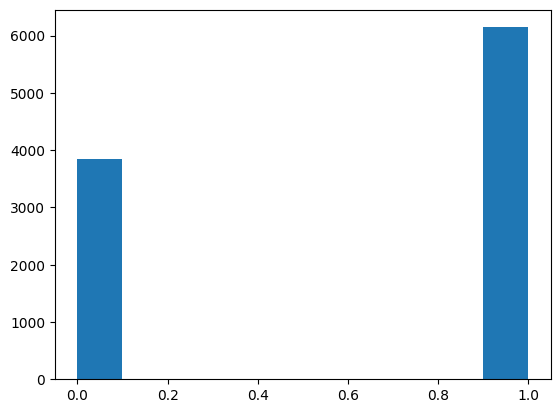

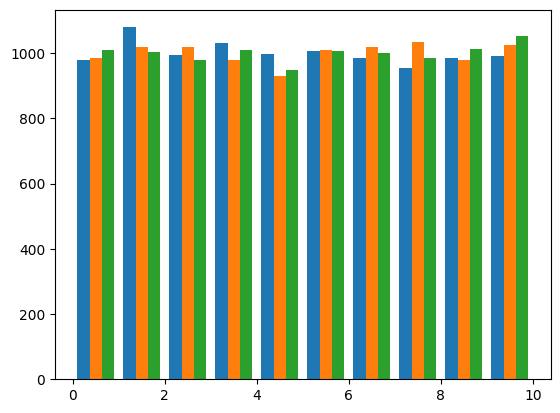

In [197]:
plt.hist(df['Target'])
plt.show()

plt.hist(df.drop('Target', axis=1))
plt.show()


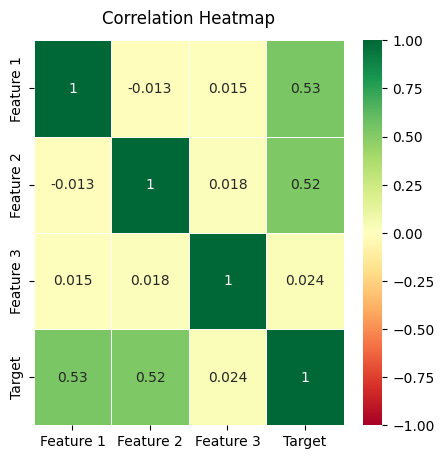

In [108]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(5,5))
#plot heat map

g=sns.heatmap(df[top_corr_features].corr(), vmin=-1, vmax=1, annot=True,cmap="RdYlGn", linewidth=0.5)
g.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('output.png', dpi=300, bbox_inches='tight')

In [237]:
sea_stream.reset()

Drift detected!
Drift detected!


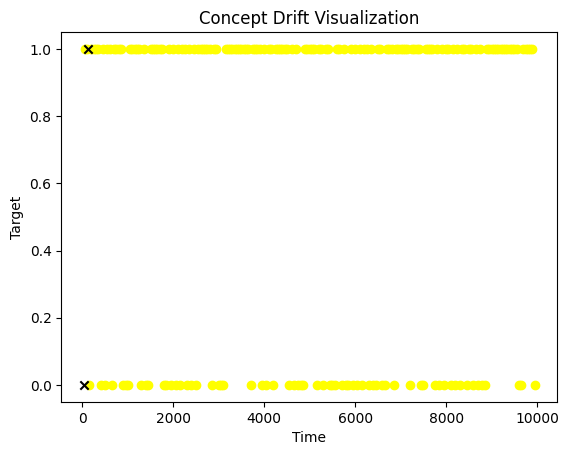

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3410
           1       0.95      0.94      0.94      6590

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [240]:
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.data import HyperplaneGenerator
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report


# stream = HyperplaneGenerator()


drift_detector = DDM(out_control_level=3.0) 
clf = GaussianNB()

curr_samples = 0
actual_drift_points = [n * 50 for n in range(1, 200)]
guessed_predictions = []
drift_points = []
features = [[], [], []]
targets = []

X, y = sea_stream.next_sample(25000)
clf.fit(X, y)

while curr_samples < N_SAMPLES and sea_stream.has_more_samples():
    if curr_samples in actual_drift_points:
        sea_stream.generate_drift()

    X, y = sea_stream.next_sample()

    prediction = clf.predict(X)

    guessed_predictions.append(prediction[0])

    features[0].append(X[0][0])
    features[1].append(X[0][1])
    features[2].append(X[0][2])
    targets.append(y[0])
    drift_detected = drift_detector.add_element(1 - int(y[0] == prediction[0]))
    if drift_detector.detected_change():
        print('Drift detected!')
        drift_points.append(curr_samples)

    clf.partial_fit(X, y)
    curr_samples += 1

df = pd.DataFrame({'Feature 1': features[0], 'Feature 2': features[1], 'Feature 3': features[2], 'Target': targets})
df.head()

plt.scatter(actual_drift_points, [targets[i] for i in actual_drift_points], color='yellow', marker='o')
plt.scatter(drift_points, [targets[i] for i in drift_points], color='black', marker='x')
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Concept Drift Visualization')
plt.show()

print(classification_report(targets, guessed_predictions, target_names=['0', '1']))

In [ ]:

from streams import *
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data import HyperplaneGenerator
from skmultiflow.data import LEDGeneratorDrift

stream = build_data_stream('covtype')


#### Create the ensemble

In [113]:
from ensemble import build_premade_ensemble, build_custom_ensemble
from sklearn.naive_bayes import GaussianNB

ensemble = build_premade_ensemble('batch', 10, GaussianNB())

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

#### Utilize drift detection methods

#### Evaluate

In [178]:
from skmultiflow.evaluation import EvaluatePrequential

evaluator = EvaluatePrequential(
    n_wait = 10,
    max_samples = 100,
    show_plot = True,
    metrics=['accuracy', 'running_time', 'accuracy', 'precision', 'gmean'],
    data_points_for_classification=True
)

evaluator.evaluate(stream=stream, model=[ensemble], model_names=['ensemble'])

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations